In [16]:
import numpy as np
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.metrics import roc_auc_score

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Necessary functions 

In [2]:
def roc_auc_ci(
        classifier: ClassifierMixin,
        X: np.ndarray,
        y: np.ndarray,
        conf: float = 0.95,
        n_bootstraps: int = 10_000
) -> Tuple[float, float]:
    """Calculates confidence interval for auc score using the bootstrap"""
    metrics = []
    i = 0
    y_pred = classifier.predict_proba(X)[:, 1]
    while i < n_bootstraps:
        btsrp_indices = list(np.random.choice(range(len(X)), len(X), replace=True))
        X_btsrp = X[btsrp_indices, :]
        y_btsrp = y[btsrp_indices]
        if len(np.unique(y_btsrp)) != 2:
            continue
        else:
            y_pred_btsrp = y_pred[btsrp_indices]
            auc = roc_auc_score(y_btsrp, y_pred_btsrp)
            metrics.append(auc)
            i += 1
    alpha = 1 - conf
    lcb = np.quantile(metrics, alpha/2)
    ucb = np.quantile(metrics, 1-alpha/2)
    return (lcb, ucb)

In [3]:
def precision_metrics(
    y_true: np.ndarray
) -> np.ndarray:
    """Calculates presicion score for sorted array"""
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    precision = tps / (tps + fps)
    return precision

In [4]:
def recall_metrics(
  y_true: np.ndarray
) -> np.ndarray:
    """Calculates recall score for sorted array"""
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    fns = tps[-1] - tps
    recall = tps / (tps + fns)
    return recall

In [5]:
def specificity_metrics(
    y_true: np.ndarray
) -> np.ndarray:
    """Calculates specificity score for sorted array"""
    fps = np.cumsum(1 - y_true)
    tns = fps[-1] - fps
    specificity = tns / (tns + fps)
    
    return specificity

In [6]:
def pr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_precision: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Precision-Recall Curve)"""  
    precision = precision_metrics(y_true)
    recall = recall_metrics(y_true)
    mask = (precision >= min_precision)
    recall_tsh = recall * mask
    max_recall = np.max(recall_tsh)
    max_idx = np.where(recall_tsh == max_recall)[0][0]
    threshold_proba = float(y_prob[max_idx])

    return threshold_proba, max_recall

In [7]:
def sr_threshold(
        y_true: np.ndarray,
        y_prob: np.ndarray,
        min_specificity: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Specificity-Recall Curve)"""
    # specificity = 1 - fpr
    # fpr = fp / (tn + fp)
    specificity = specificity_metrics(y_true)
    recall = recall_metrics(y_true)
    mask = (specificity >= min_specificity)
    recall_tsh = recall * mask
    max_recall = np.max(recall_tsh)
    max_idx = np.where(recall_tsh == max_recall)[0][0]
    threshold_proba = float(y_prob[max_idx])

    return threshold_proba, max_recall

In [8]:
def sr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Specificity-Recall curve and it's (LCB, UCB)"""
    specificity_btstrp = []
    recall = recall_metrics(y_true)
    specificity = specificity_metrics(y_true)
    i = 0
    while i < n_bootstrap:
        btsrp_indices = np.sort(np.random.choice(range(len(y_true)), len(y_true), replace=True))
        y_true_btstrp = y_true[btsrp_indices]
        if len(np.unique(y_true_btstrp)) != 2:
            continue
        specificity_curr = specificity_metrics(y_true_btstrp)
        specificity_curr = np.insert(specificity_curr, 0, 1)
        specificity_btstrp = np.concatenate((specificity_btstrp, specificity_curr), axis=0)
        i += 1
    specificity_btstrp = specificity_btstrp.reshape(n_bootstrap, -1)
    alpha = 1 - conf
    specificity_lcb = np.quantile(specificity_btstrp, alpha / 2, axis=0)
    specificity_ucb = np.quantile(specificity_btstrp, 1 - alpha / 2, axis=0)
    recall = np.insert(recall, 0, 0)
    specificity = np.insert(specificity, 0, 1)

    return recall, specificity, specificity_lcb, specificity_ucb

In [9]:
def pr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Precision-Recall curve and it's (LCB, UCB)"""
    precision_btstrp = []
    recall = recall_metrics(y_true)
    precision = precision_metrics(y_true)
    i = 0
    while i < n_bootstrap:
        btsrp_indices = np.sort(np.random.choice(range(len(y_true)), len(y_true), replace=True))
        y_true_btstrp = y_true[btsrp_indices]
        if len(np.unique(y_true_btstrp)) != 2:
            continue
        precision_curr = precision_metrics(y_true_btstrp)
        precision_curr = np.insert(precision_curr, 0, 1)
        precision_btstrp = np.concatenate((precision_btstrp, precision_curr), axis=0)
        i += 1
    precision_btstrp = precision_btstrp.reshape(n_bootstrap, -1)
    alpha = 1 - conf
    precision_lcb = np.quantile(precision_btstrp, alpha / 2, axis=0)
    precision_ucb = np.quantile(precision_btstrp, 1 - alpha / 2, axis=0)
    recall = np.insert(recall, 0, 0)
    precision = np.insert(precision, 0, 1)

    return recall, precision, precision_lcb, precision_ucb

### Apply functions on synthetic data from sklearn

In [11]:
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=5,
                                    n_informative=3,
                                    )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [12]:
y_prob = classifier.predict_proba(X_test)[:, 1]

In [15]:
print(f'The roc auc is {roc_auc_score(y_test, y_prob)}')

The roc auc is 0.9251256057978747


Let's find the 95 % confidence interval for the classifier

In [14]:
(lcb, ucb) = roc_auc_ci(classifier, X_test, y_test)
print(f'The 95% confidence interval is {(lcb, ucb)}')

The 95% confidence interval is (0.8943503560781935, 0.9523919185324738)


Let's plot the precision-recall and specificity-recall curves

In [17]:
#sort targets in reverse order to calculate metrics
ind = y_prob.argsort()[::-1]
y_test = y_test[ind]

In [18]:
recall_precision, precision, lcb_precision, ucb_precision = pr_curve(y_test, y_prob, n_bootstrap=10000)

In [20]:
recall_specificity, specificity, lcb_specificity, ucb_specificity = sr_curve(y_test, y_prob, n_bootstrap=10000)

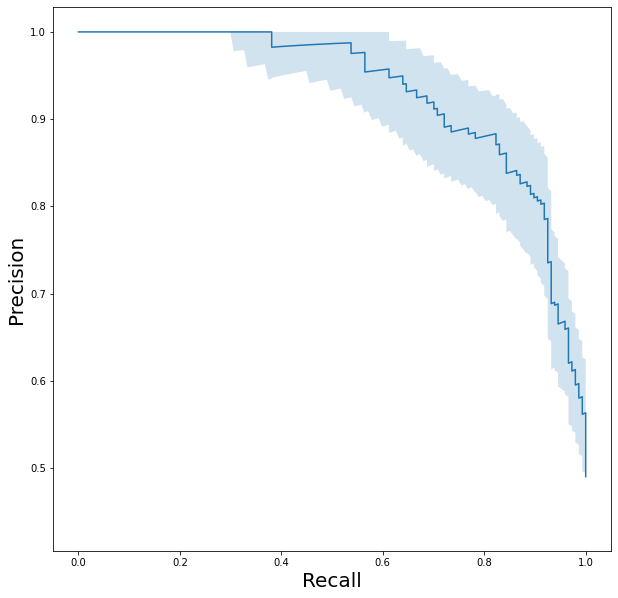

In [19]:
fig = plt.figure(figsize=(10,10))
plt.plot(recall_precision, precision)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.fill_between(recall_precision, lcb_precision, ucb_precision, alpha=0.2)

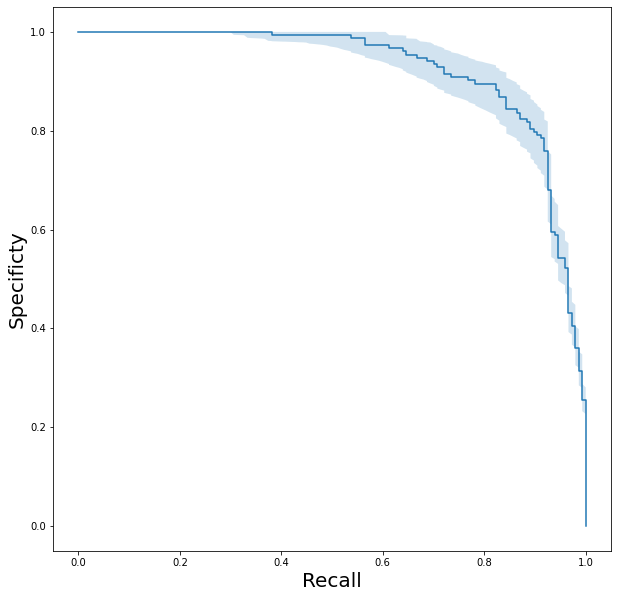

In [21]:
fig = plt.figure(figsize=(10,10))
plt.plot(recall_specificity, specificity)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Specificty', fontsize=20)
plt.fill_between(recall_specificity, lcb_specificity, ucb_specificity, alpha=0.2)

Let's find the threshold probability with precision (specificity) not less than some value, and max recall 

In [22]:
pr_threshold(y_test, y_prob, 0.6)

(0.9999484869612649, 0.9795918367346939)

Thus, the 0.9999484869612649 is threshold probability corresponding to maximum value of recall and precision > 0.6

In [23]:
sr_threshold(y_test, y_prob, 0.8)

(0.9311978162451999, 0.8979591836734694)

Thus, the 0.9311978162451999 is threshold probability corresponding to maximum value of recall and specificity > 0.8